In [2771]:
import os
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from plotly.subplots import make_subplots
from concurrent.futures import ProcessPoolExecutor as Pool
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
pio.kaleido.scope.mathjax = None
pd.options.display.max_rows = None

In [2772]:
LOGDIR = "logs"
ALGOS = ["bc", "bcq", "cql", "icq", "omar", "omiga", "madice", "madice-twolayer"]
# ALGOS = ["madice"]
SEEDS = [0, 1, 2, 3, 4]
SMACV1_ENV_NAMES = ["2c_vs_64zg", "5m_vs_6m", "6h_vs_8z", "corridor"]
SMACV2_ENV_NAMES = ["protoss", "terran", "zerg"]
MAMUJOCO_ENV_NAMES = ["Hopper-v2", "Ant-v2", "HalfCheetah-v2"]
SMACV1_MODES = ["poor", "medium", "good"]
SMACV2_MODES = ["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]
MAMUJOCO_MODES = ["expert", "medium", "medium-replay", "medium-expert"]

colors = px.colors.qualitative.Plotly
COLOR_MAPS = {
    "omiga": colors[0],
    "madice": colors[1],
    "madice-twolayer": "#ef823b",
    "icq": colors[2],
    "cql": colors[5],
    "bcq": "#4ba5ff",
    "bc": "#feb406",
    "omar": "#d366ff",
}
os.makedirs("graphs", exist_ok=True)

In [2773]:
COLOR_MAPS

{'omiga': '#636EFA',
 'madice': '#EF553B',
 'madice-twolayer': '#ef823b',
 'icq': '#00CC96',
 'cql': '#19D3F3',
 'bcq': '#4ba5ff',
 'bc': '#feb406',
 'omar': '#d366ff'}

In [2774]:
def listdir(path):
    if not os.path.exists(path):
        return []
    return sorted(os.listdir(path))

In [2775]:
def read_tensorboard(logdir):
    files = listdir(logdir)
    if len(files) == 0:
        return {}
    path = f"{logdir}/{files[0]}"
    tb = EventAccumulator(path)
    tb.Reload()
    data = {}
    for tag in ["return", "winrate"]:
        if f"game/{tag}" in tb.Tags()["scalars"]:
            for item in tb.Scalars(f"game/{tag}"):
                if item.step not in data:
                    data[item.step] = {}
                data[item.step][tag] = item.value
    return data

In [2776]:
def create_tasks(algo, env_name, mode):
    for seed in listdir(f"{LOGDIR}/{algo}/{env_name}/{mode}"):
        for alpha in listdir(f"{LOGDIR}/{algo}/{env_name}/{mode}/{seed}"):
            for f_func in listdir(f"{LOGDIR}/{algo}/{env_name}/{mode}/{seed}/{alpha}"):
                logdir = f"{LOGDIR}/{algo}/{env_name}/{mode}/{seed}/{alpha}/{f_func}"
                yield logdir, alpha, f_func

In [2777]:
def create_smacv1_tasks(p):
    tasks = []
    for algo in ALGOS:
        for env_name in SMACV1_ENV_NAMES:
            for mode in SMACV1_MODES:
                for logdir, alpha, f_func in create_tasks(algo, env_name, mode):
                    tasks.append((p.submit(read_tensorboard, logdir), env_name, mode, algo, alpha, f_func))
    return tasks

In [2778]:
def create_smacv2_tasks(p):
    tasks = []
    for algo in ALGOS:
        for env_name in SMACV2_ENV_NAMES:
            for mode in SMACV2_MODES:
                for logdir, alpha, f_func in create_tasks(algo, f"{env_name}_{mode}", "medium"):
                    tasks.append((p.submit(read_tensorboard, logdir), env_name, mode, algo, alpha, f_func))
    return tasks

In [2779]:
def create_mamujoco_tasks(p):
    tasks = []
    for algo in ALGOS:
        for env_name in MAMUJOCO_ENV_NAMES:
            for mode in MAMUJOCO_MODES:
                for logdir, alpha, f_func in create_tasks(algo, env_name, mode):
                    tasks.append((p.submit(read_tensorboard, logdir), env_name, mode, algo, alpha, f_func))
    return tasks

In [2780]:
results = {}
with Pool() as p:
    tasks = []
    tasks += create_smacv1_tasks(p)
    tasks += create_smacv2_tasks(p)
    tasks += create_mamujoco_tasks(p)
    
    for task, env_name, mode, algo, alpha, f_func in tqdm(tasks):
        data = task.result()
        if len(data) == 0:
            continue
        color = COLOR_MAPS[algo]
        if algo == "madice":
            algo = "ComaDICE (ours)"
        elif algo == "madice-twolayer":
            algo = "ComaDICE (2-layer)"
        else:
            algo = algo.upper()
        COLOR_MAPS[algo] = color
        if (env_name, mode) not in results:
            results[(env_name, mode)] = {}
        if (algo, alpha, f_func) not in results[(env_name, mode)]:
            results[(env_name, mode)][(algo, alpha, f_func)] = []
        results[(env_name, mode)][(algo, alpha, f_func)].append(data)

100%|██████████| 2730/2730 [00:00<00:00, 480142.99it/s]


In [2781]:
os.makedirs("saved_results", exist_ok=True)
with open("saved_results/log_data.pkl", "wb") as f:
    pickle.dump(data, f)

In [2782]:
main_results = {}
for (env_name, mode), data in results.items():
    for (algo, alpha, f_func), items in data.items():
        if alpha != "alpha10" or f_func != "soft_chisquare":
            continue
        if "2-layer" in algo:
            continue
        if (env_name, mode) not in main_results:
            main_results[(env_name, mode)] = {}
        main_results[(env_name, mode)][algo] = items

In [2783]:
ablation_results = {}
for (env_name, mode), data in results.items():
    for (algo, alpha, f_func), items in data.items():
        if algo != "ComaDICE (ours)":
            continue
        if (env_name, mode) not in ablation_results:
            ablation_results[(env_name, mode)] = {}
        ablation_results[(env_name, mode)][(alpha, f_func)] = items

In [2784]:
ablation_mixer_results = {}
for (env_name, mode), data in results.items():
    for (algo, alpha, f_func), items in data.items():
        if alpha != "alpha10" or f_func != "soft_chisquare":
            continue
        if "ComaDICE" not in algo:
            continue
        if (env_name, mode) not in ablation_mixer_results:
            ablation_mixer_results[(env_name, mode)] = {}
        ablation_mixer_results[(env_name, mode)][algo] = items

In [2785]:
def analyze(items, tag="return"):
    if not isinstance(items, list):
        return np.nan
    items = [item[max(item.keys())] for item in items]
    items = [item[tag] for item in items if tag in item]
    if len(items) == 0:
        return np.nan
    mean = np.mean(items)
    std = np.std(items)
    if tag == "winrate":
        return f"{mean*100:.2f}±{std*100:.2f}"
    else:
        return f"{mean:.2f}±{std:.2f}"

In [2786]:
pd.DataFrame.from_dict(main_results).map(analyze, tag="return").T

BC              BCQ  \
2c_vs_64zg     poor               11.56±0.39       12.46±0.18   
               medium             13.37±1.87       15.58±0.37   
               good               17.90±1.30       19.13±0.27   
5m_vs_6m       poor                6.98±0.47        7.61±0.36   
               medium              7.05±0.82        7.58±0.10   
               good                6.95±0.47        7.76±0.15   
6h_vs_8z       poor                8.57±0.81       10.84±0.16   
               medium              9.46±0.35       11.77±0.16   
               good               10.02±1.67       12.19±0.23   
corridor       poor                2.91±0.57        4.47±0.94   
               medium              7.39±0.79       10.82±0.92   
               good               10.81±2.61       15.24±1.21   
protoss        5_vs_5             13.24±0.68        6.84±1.61   
               10_vs_10           12.00±1.91        7.72±1.32   
               10_vs_11           11.17±0.53        5.18±1.43   
               20_vs_20           13.14±0.45        4.82±0.58   
               20_vs_23           11.20±0.52        3.54±0.64   
terran         5_vs_5             10.83±1.44        6.36±1.05   
               10_vs_10           10.30±0.33        4.58±0.40   
               10_vs_11            8.98±0.69        3.61±1.14   
               20_vs_20           10.81±0.77        3.95±0.60   
               20_vs_23            7.20±0.98        1.22±0.97   
zerg           5_vs_5             10.49±2.22        6.57±0.22   
               10_vs_10           10.96±0.78        7.27±1.05   
               10_vs_11            9.23±1.11        7.60±0.87   
               20_vs_20            9.28±0.47        3.69±0.40   
               20_vs_23            8.54±0.73        3.28±0.30   
Hopper-v2      expert          209.85±191.12      77.85±58.04   
               medium            511.95±7.43      44.58±20.62   
               medium-replay    133.31±53.54      26.53±24.04   
               medium-expert   155.30±111.53      54.31±23.66   
Ant-v2         expert           2046.31±6.18   1317.73±286.28   
               medium           1421.09±7.88    1059.60±91.22   
               medium-replay    994.00±20.29     950.77±48.76   
               medium-expert   1561.70±64.81   1020.89±242.74   
HalfCheetah-v2 expert         3251.22±386.83   2992.71±629.65   
               medium         2280.32±178.22  2590.47±1110.35   
               medium-replay  1886.20±390.77   -333.64±152.06   
               medium-expert  2451.95±782.99   3543.70±780.89   

                                          CQL             ICQ  \
2c_vs_64zg     poor                10.83±0.51      12.56±0.18   
               medium              12.82±1.61      15.57±0.61   
               good                18.48±0.95      18.82±0.17   
5m_vs_6m       poor                 7.43±0.10       7.26±0.19   
               medium               7.78±0.10       7.77±0.30   
               good                 8.08±0.21       7.87±0.30   
6h_vs_8z       poor                10.81±0.52      10.55±0.10   
               medium              11.29±0.29      11.13±0.33   
               good                10.44±0.20      11.81±0.12   
corridor       poor                 4.08±0.60       4.47±0.33   
               medium               7.04±0.66      11.30±1.57   
               good                 5.22±0.81      15.54±1.12   
protoss        5_vs_5               9.31±1.64      10.72±1.16   
               10_vs_10            11.27±0.92      10.42±1.57   
               10_vs_11             7.95±0.76      10.33±0.66   
               20_vs_20            10.49±0.94      11.79±0.49   
               20_vs_23             5.57±0.75      10.20±0.67   
terran         5_vs_5               6.51±0.86       6.78±0.58   
               10_vs_10             6.82±0.62       8.75±1.45   
               10_vs_11             5.46±0.23       5.52±0.87   
               20_vs_20             4.32±0.61       8.33±0.31   
           

In [2787]:
pd.DataFrame.from_dict(ablation_results).map(analyze, tag="return").T

alpha0.01        alpha0.1           alpha1  \
                              soft_chisquare  soft_chisquare   soft_chisquare   
2c_vs_64zg     poor               10.56±0.54      11.08±0.36       11.12±0.13   
               medium              9.63±0.46      13.07±0.78       12.54±2.39   
               good               11.05±1.39       9.58±2.67       17.43±0.50   
5m_vs_6m       poor                5.71±0.11       5.06±0.26        7.08±0.71   
               medium              5.60±0.14       5.29±0.16        7.77±0.77   
               good                5.72±0.10       5.70±0.19        7.75±0.49   
6h_vs_8z       poor                8.54±0.24       9.60±0.28       10.00±0.33   
               medium              8.54±0.59      10.47±0.80       10.75±0.49   
               good                7.87±0.11       9.50±0.55       11.34±0.56   
corridor       poor                2.07±0.43       3.73±0.96        6.09±0.83   
               medium              1.68±1.03       2.22±1.66       11.34±0.29   
               good                4.74±2.39       3.82±4.99       15.66±0.29   
protoss        5_vs_5             12.21±1.05      13.08±1.28       13.22±1.06   
               10_vs_10           12.85±0.89      13.98±0.84       13.44±1.19   
               10_vs_11            9.89±1.09      11.14±0.78       11.29±1.20   
               20_vs_20           10.25±0.53      11.12±1.02       12.22±0.85   
               20_vs_23            7.98±2.32      11.22±1.22       11.70±0.56   
terran         5_vs_5             11.06±1.83      10.09±1.16        9.01±0.98   
               10_vs_10            8.51±0.76      10.34±0.66       10.39±1.14   
               10_vs_11            7.46±0.71       8.57±2.10        8.49±1.64   
               20_vs_20            6.24±1.13       6.42±1.71        9.06±0.71   
               20_vs_23            5.47±1.14       6.48±1.61        6.47±0.75   
zerg           5_vs_5              7.89±0.64       9.34±0.86       10.53±1.38   
               10_vs_10           10.85±1.46      11.42±1.52       11.77±0.70   
               10_vs_11           10.09±2.48       9.07±1.22        9.96±1.23   
               20_vs_20            7.99±0.48       9.20±1.34        9.20±1.02   
               20_vs_23            9.07±1.09       9.97±0.66       10.43±0.63   
Hopper-v2      expert           147.31±67.94    107.85±65.54    545.67±820.56   
               medium           149.62±96.75    107.54±66.86    244.66±267.46   
               medium-replay   165.64±104.09    109.56±38.68     155.60±61.61   
               medium-expert    119.12±77.13     95.57±69.53      58.75±26.06   
Ant-v2         expert         1016.36±196.48  1179.05±273.70   1927.73±174.10   
               medium           907.33±32.23   1000.05±90.37     1424.33±3.09   
               medium-replay    969.09±21.92    978.43±39.59     944.59±28.94   
               medium-expert   915.76±364.10  1132.93±282.16    738.47±250.19   
HalfCheetah-v2 expert         1068.91±635.24   935.17±905.86    3636.95±80.87   
               medium          575.92±724.82   445.19±403.87    2690.00±92.38   
               medium-replay   412.30±310.54   233.49±270.11    861.58±173.54   
               medium-expert  -107.50±298.07  -275.92±544.54  1136.90±1608.33   

                                     alpha10                                   \
                                   chisquare               kl  soft_chisquare   
2c_vs_64zg     poor               11.64±0.24       11.10±0.31      12.15±0.51   
               medium             16.06±0.59       15.69±0.26      16.30±0.66   
               good               19.74±0.10       19.30±0.06      20.34±0.06   
5m_vs_6m       poor                7.78±0.37        7.49±0.49       8.12±0.55   
               medium              8.09±0.46        7.74±0.39       8.65±0.38   
               good                8.68±0.57        8.11±0.44       8.66±0.50   
6h_vs_8z       poor               10.54±0.26       10.00±0.20    

In [2788]:
pd.DataFrame.from_dict(ablation_mixer_results).map(analyze, tag="return").T

ComaDICE (ours) ComaDICE (2-layer)
2c_vs_64zg     poor               12.15±0.51         11.45±0.88
               medium             16.30±0.66         11.21±0.85
               good               20.34±0.06          9.01±2.19
5m_vs_6m       poor                8.12±0.55          3.81±1.10
               medium              8.65±0.38          0.78±0.27
               good                8.66±0.50          7.69±0.14
6h_vs_8z       poor               11.37±0.58         10.30±0.34
               medium             12.83±0.22          9.06±0.62
               good               13.11±0.46          8.30±0.49
corridor       poor                6.36±0.47          1.47±0.75
               medium             12.90±0.62          3.90±1.70
               good               17.98±0.08          2.55±2.30
protoss        5_vs_5             14.41±1.15         10.54±1.45
               10_vs_10           14.55±1.81         11.23±1.61
               10_vs_11           13.18±0.86          9.48±0.45
               20_vs_20           14.83±0.99          9.54±0.90
               20_vs_23           13.26±0.90          7.09±2.16
terran         5_vs_5             10.70±1.53          8.30±0.80
               10_vs_10           11.82±0.90          8.84±1.08
               10_vs_11            9.40±0.95          6.36±1.16
               20_vs_20           11.81±0.46          7.80±0.93
               20_vs_23            8.21±0.72          6.61±0.89
zerg           5_vs_5             10.68±1.96          7.77±1.15
               10_vs_10           11.46±0.95          9.69±0.61
               10_vs_11           11.01±0.94          7.85±0.71
               20_vs_20            9.42±1.16          7.85±0.57
               20_vs_23           10.51±0.79          8.02±0.52
Hopper-v2      expert          2827.70±62.91      483.74±349.69
               medium           822.55±66.21      648.40±245.89
               medium-replay   906.25±242.13      441.87±260.77
               medium-expert  1362.44±522.87      402.28±288.17
Ant-v2         expert           2056.89±5.92     1582.97±160.42
               medium           1425.00±2.87      1198.87±53.92
               medium-replay   1122.94±61.04      1041.78±38.41
               medium-expert   1813.88±68.37     1426.63±171.41
HalfCheetah-v2 expert          4082.93±45.68     2159.39±658.01
               medium          2664.71±54.19     2026.66±244.30
               medium-replay  2855.02±242.25     1299.18±196.11
               medium-expert   3889.74±81.64     1336.27±381.88

In [2789]:
pd.DataFrame.from_dict(main_results).map(analyze, tag="winrate").T

BC         BCQ          CQL  \
2c_vs_64zg     poor             0.00±0.00   0.00±0.00    0.00±0.00   
               medium           1.88±1.53   2.50±3.64    2.50±3.64   
               good            31.25±9.88  35.62±8.75  44.38±13.02   
5m_vs_6m       poor             2.50±1.25   1.25±1.53    1.25±1.53   
               medium           1.88±1.53   1.25±1.53    2.50±1.25   
               good             2.50±2.34   1.88±2.50    1.88±1.53   
6h_vs_8z       poor             0.00±0.00   0.00±0.00    0.00±0.00   
               medium           1.88±1.53   1.88±1.53    1.88±1.53   
               good             8.75±1.25   8.75±3.64    7.50±1.53   
corridor       poor             0.00±0.00   0.00±0.00    0.00±0.00   
               medium          15.00±2.34  23.12±1.53   14.37±1.53   
               good            30.63±4.15  42.50±6.43    5.62±1.25   
protoss        5_vs_5          36.88±8.71  16.25±2.34   10.00±4.15   
               10_vs_10       36.25±10.57   9.38±5.59   26.25±7.55   
               10_vs_11        19.38±4.59  10.00±4.15   10.62±5.45   
               20_vs_20        37.50±4.42   6.25±1.98   11.88±4.15   
               20_vs_23        13.75±1.53   1.25±1.53    0.00±0.00   
terran         5_vs_5          30.00±4.24  12.50±6.25    9.38±7.91   
               10_vs_10        29.38±5.80   6.88±6.06    9.38±5.59   
               10_vs_11        16.25±3.64   3.75±4.59    7.50±6.43   
               20_vs_20       26.25±10.38   5.00±3.19   10.62±4.24   
               20_vs_23         4.38±4.24   0.00±0.00    0.00±0.00   
zerg           5_vs_5         26.88±10.00  14.37±4.24   14.37±5.80   
               10_vs_10        25.00±2.80   5.62±4.59    5.62±4.59   
               10_vs_11        13.75±4.68   9.38±5.23    6.25±4.42   
               20_vs_20         8.12±1.53   2.50±1.25    1.25±1.53   
               20_vs_23         7.50±3.19   0.62±1.25    1.25±1.53   
Hopper-v2      expert                 NaN         NaN          NaN   
               medium                 NaN         NaN          NaN   
               medium-replay          NaN         NaN          NaN   
               medium-expert          NaN         NaN          NaN   
Ant-v2         expert                 NaN         NaN          NaN   
               medium                 NaN         NaN          NaN   
               medium-replay          NaN         NaN          NaN   
               medium-expert          NaN         NaN          NaN   
HalfCheetah-v2 expert                 NaN         NaN          NaN   
               medium                 NaN         NaN          NaN   
               medium-replay          NaN         NaN          NaN   
               medium-expert          NaN         NaN          NaN   

                                     ICQ        OMAR        OMIGA  \
2c_vs_64zg     poor            0.00±0.00   0.00±0.00    0.00±0.00   
               medium          1.88±1.53   1.25±1.53    6.25±5.59   
               good           28.75±4.59  28.75±9.14   40.62±9.48   
5m_vs_6m       poor            1.25±1.53   0.62±1.25    6.88±1.25   
               medium          1.25±1.53   0.62±1.25    2.50±3.06   
               good            3.75±2.34   3.75±1.25    6.88±1.25   
6h_vs_8z       poor            0.00±0.00   0.00±0.00    0.00±0.00   
               medium          2.50±1.25   1.88±1.53    1.25±1.53   
               good            9.38±1.98   0.62±1.25    5.62±3.64   
corridor       poor            0.62±1.25   0.00±0.00    0.00±0.00   
               medium         22.50±3.06  11.88±2.34   23.75±5.08   
               good           42.50±6.43   3.12±0.00   41.88±6.43   
protoss        5_vs_5         36.88±9.14  21.25±4.15   33.12±5.45   
               10_vs_10       28.12±6.56  13.75±7.02  40.00±10.72   
               10_vs_11       12.50±4.42  12.50±3.42   16.25±6.06   
               20_vs_20       32.50±8.05  23.75±2.50   36.25±5.08   
               20_vs_23       12.50±5.59  11.25±7.81   12.50±8.15

In [2790]:
pd.DataFrame.from_dict(ablation_results).map(analyze, tag="winrate").T

alpha0.01       alpha0.1         alpha1  \
                             soft_chisquare soft_chisquare soft_chisquare   
2c_vs_64zg     poor               0.00±0.00      0.00±0.00      0.00±0.00   
               medium             0.00±0.00      1.88±3.75      5.00±5.08   
               good               0.62±1.25      0.00±0.00     40.62±3.95   
5m_vs_6m       poor               0.00±0.00      0.00±0.00      4.38±4.68   
               medium             0.00±0.00      0.00±0.00      8.12±6.43   
               good               0.00±0.00      0.00±0.00      6.25±4.42   
6h_vs_8z       poor               0.00±0.00      0.00±0.00      1.88±3.75   
               medium             0.00±0.00      0.62±1.25      1.88±1.53   
               good               0.00±0.00      0.00±0.00      7.50±5.80   
corridor       poor               0.00±0.00      0.62±1.25      0.00±0.00   
               medium             0.00±0.00      0.00±0.00     30.00±5.08   
               good               0.00±0.00      4.38±8.75     48.75±4.68   
protoss        5_vs_5           20.62±10.00     31.87±6.06     50.00±2.80   
               10_vs_10          19.38±6.06     25.00±3.42    45.00±11.11   
               10_vs_11           0.00±0.00      6.25±9.68     18.75±8.15   
               20_vs_20           1.25±1.53      8.75±7.76     28.12±8.62   
               20_vs_23           0.00±0.00      1.88±2.50      9.38±6.56   
terran         5_vs_5            25.62±4.59     22.50±7.23     30.63±4.15   
               10_vs_10          15.00±8.71     28.75±7.23     33.75±9.35   
               10_vs_11           3.75±2.34     13.75±9.19     14.37±9.19   
               20_vs_20           0.62±1.25      2.50±3.64     18.75±1.98   
               20_vs_23           0.62±1.25      2.50±3.64      2.50±3.64   
zerg           5_vs_5            10.00±4.59     20.00±5.80     28.75±4.59   
               10_vs_10          13.75±8.97     20.62±8.29     29.38±8.97   
               10_vs_11           9.38±9.48     12.50±6.85     16.88±3.19   
               20_vs_20           0.00±0.00      1.88±1.53      6.88±6.06   
               20_vs_23           1.25±1.53      3.75±2.34     12.50±3.95   
Hopper-v2      expert                   NaN            NaN            NaN   
               medium                   NaN            NaN            NaN   
               medium-replay            NaN            NaN            NaN   
               medium-expert            NaN            NaN            NaN   
Ant-v2         expert                   NaN            NaN            NaN   
               medium                   NaN            NaN            NaN   
               medium-replay            NaN            NaN            NaN   
               medium-expert            NaN            NaN            NaN   
HalfCheetah-v2 expert                   NaN            NaN            NaN   
               medium                   NaN            NaN            NaN   
               medium-replay            NaN            NaN            NaN   
               medium-expert            NaN            NaN            NaN   

                                  alpha10                              \
                                chisquare           kl soft_chisquare   
2c_vs_64zg     poor             0.00±0.00    0.00±0.00      0.62±1.25   
               medium          13.12±4.59   10.62±3.75      8.75±6.96   
               good            55.62±3.06   54.37±1.53     55.00±1.53   
5m_vs_6m       poor             3.75±3.06    3.75±3.64      4.38±4.24   
               medium           6.25±2.80    5.00±3.75      7.50±2.50   
               good             8.75±3.64    6.88±3.06      8.12±3.19   
6h_vs_8z       poor             0.00±0.00    0.00±0.00      1.88±3.75   
               medium           5.00±2.50    5.00±3.75      3.12±1.98   
               good             9.38±4.42    9.38±1.98     11.25±5.45   
corridor       poor             1.25±1.53    1.25±1.53      0.62±1.25   


In [2791]:
pd.DataFrame.from_dict(ablation_mixer_results).map(analyze, tag="winrate").T

ComaDICE (ours) ComaDICE (2-layer)
2c_vs_64zg     poor                0.62±1.25          0.00±0.00
               medium              8.75±6.96          3.75±3.64
               good               55.00±1.53         19.38±5.00
5m_vs_6m       poor                4.38±4.24          3.12±0.00
               medium              7.50±2.50          1.25±1.53
               good                8.12±3.19          3.12±0.00
6h_vs_8z       poor                1.88±3.75          0.00±0.00
               medium              3.12±1.98          0.00±0.00
               good               11.25±5.45          1.88±2.50
corridor       poor                0.62±1.25          0.00±0.00
               medium             27.34±3.41         11.25±2.50
               good               48.75±2.50         23.12±8.05
protoss        5_vs_5             46.25±6.06         31.87±3.64
               10_vs_10           50.62±8.71         32.50±5.80
               10_vs_11           20.00±4.24         10.62±7.29
               20_vs_20           47.50±7.76         21.88±3.95
               20_vs_23           13.75±5.80          6.88±5.38
terran         5_vs_5             30.63±8.24         25.62±4.59
               10_vs_10           32.50±5.80         28.12±3.42
               10_vs_11           19.38±5.38         12.50±3.95
               20_vs_20           29.38±3.75         11.25±3.19
               20_vs_23            9.38±5.23          3.12±1.98
zerg           5_vs_5             31.25±7.65         20.62±4.68
               10_vs_10          33.75±11.76         21.25±7.23
               10_vs_11           19.38±3.64         13.12±4.15
               20_vs_20            9.38±6.25          5.62±1.25
               20_vs_23           11.25±4.24          3.12±3.42
Hopper-v2      expert                    NaN                NaN
               medium                    NaN                NaN
               medium-replay             NaN                NaN
               medium-expert             NaN                NaN
Ant-v2         expert                    NaN                NaN
               medium                    NaN                NaN
               medium-replay             NaN                NaN
               medium-expert             NaN                NaN
HalfCheetah-v2 expert                    NaN                NaN
               medium                    NaN                NaN
               medium-replay             NaN                NaN
               medium-expert             NaN                NaN

In [2792]:
def select_results(results, select_alpha=True, tag="return"):
    new_results = {}
    for (env_name, mode), data in results.items():
        for algo, items in data.items():
            if isinstance(algo, tuple):
                if select_alpha:
                    algo = algo[0]
                else:
                    if algo[0] != "alpha10":
                        continue
                    algo = algo[1]
            if tag == "winrate" and env_name in MAMUJOCO_ENV_NAMES:
                continue
            if env_name not in new_results:
                new_results[env_name] = defaultdict(list)
            items = [item[max(item.keys())] for item in items]
            items = [item[tag] for item in items if tag in item]
            new_results[env_name][algo] += items
    return new_results

In [2793]:
def create_box_figure(data, min_y, max_y, tag="return"):
    fig = go.Figure()
    for alpha, items in data.items():
        name = alpha.replace("alpha", "")
        fig.add_trace(go.Box(y=items, name=name, marker_color=colors[0], boxpoints=False))
    fig.update_layout(template='simple_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
    fig.update_layout(height=120, width=160)
    if tag == "return":
        fig.update_yaxes(range=[min_y, max_y], tickformat="~s")
    else:
        fig.update_yaxes(range=[min_y, max_y], tickformat=".0%")
    fig.update_layout(showlegend=False)
    return fig

In [2794]:
def show_box(alpha_box_figures, env_names, tag="returns", y_range=None):
    fig = make_subplots(rows=1, cols=len(env_names), subplot_titles=env_names)
    for i, env_name in enumerate(env_names):
        plotly_fig = alpha_box_figures[env_name]
        plotly_fig.write_image(f"graphs/{env_name}_box_{tag}.pdf")
        fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
    fig.update_layout(template='simple_white', margin=dict(l=40, r=40, t=40, b=40, pad=0, autoexpand=True))
    fig.update_layout(height=180, width=200*len(env_names))
    if tag == "winrates":
        tickformat = ".0%"
    else:
        tickformat = "~s"
    fig.update_yaxes(range=y_range, tickformat=tickformat)
    fig.update_layout(showlegend=False)
    fig.show("svg")

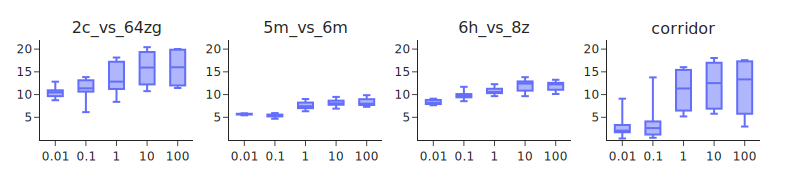

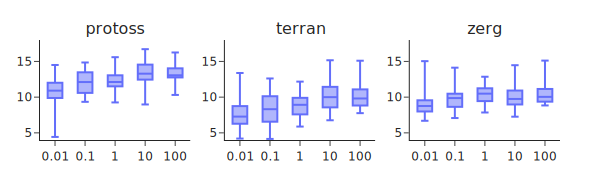

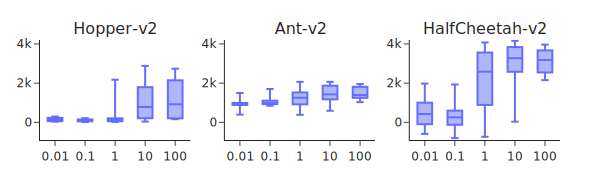

In [2795]:
alpha_results = select_results(ablation_results, tag="return")
alpha_box_figures = {}
y_range_dict = {
    "smacv1": (0.01, 22),
    "smacv2": (4, 18),
    "mamujoco": (-900, 4200),
}
for env_name, data in alpha_results.items():
    if env_name in SMACV1_ENV_NAMES:
        min_y, max_y = y_range_dict["smacv1"]
    elif env_name in SMACV2_ENV_NAMES:
        min_y, max_y = y_range_dict["smacv2"]
    else:
        min_y, max_y = y_range_dict["mamujoco"]
    alpha_box_figures[env_name] = create_box_figure(data, min_y, max_y, tag="return")
    
show_box(alpha_box_figures, SMACV1_ENV_NAMES, tag="returns", y_range=y_range_dict["smacv1"])
show_box(alpha_box_figures, SMACV2_ENV_NAMES, tag="returns", y_range=y_range_dict["smacv2"])
show_box(alpha_box_figures, MAMUJOCO_ENV_NAMES, tag="returns", y_range=y_range_dict["mamujoco"])

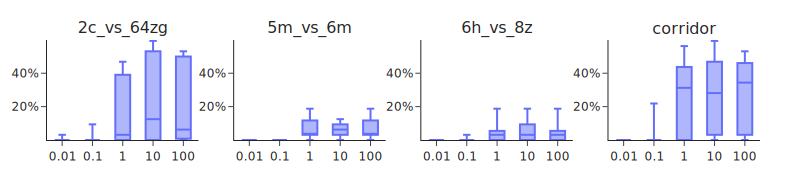

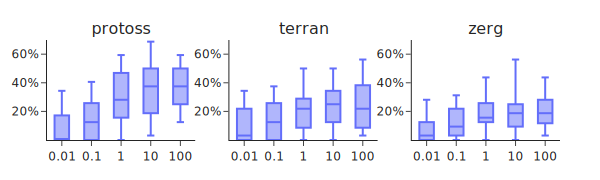

In [2796]:
alpha_results = select_results(ablation_results, tag="winrate")
alpha_box_figures = {}
for env_name, data in alpha_results.items():
    min_y, max_y = (1e-4, 0.599) if env_name in SMACV1_ENV_NAMES else (1e-4, 0.699)
    alpha_box_figures[env_name] = create_box_figure(data, min_y, max_y, tag="winrate")
    
show_box(alpha_box_figures, SMACV1_ENV_NAMES, tag="winrates", y_range=(1e-4, 0.599))
show_box(alpha_box_figures, SMACV2_ENV_NAMES, tag="winrates", y_range=(1e-4, 0.699))

In [2797]:
def smooth(scalars, weight):
    last = 0
    smoothed = []
    for num_acc, next_val in enumerate(scalars):
        last = last * weight + (1 - weight) * next_val
        smoothed.append(last / (1 - math.pow(weight, num_acc+1)))
    return smoothed

In [2798]:
def create_scatters(data, y_range=None, tag="return", smooth_weight=0.5):
    fig = go.Figure()
    all_values = []
    for algo, items in data.items():
        all_items = defaultdict(list)
        for item in items:
            for key, value in item.items():
                if tag in value:
                    all_items[key].append(value[tag])
        
        if len(all_items) == 0:
            continue
        if "2-layer" in algo:
            continue
        
        steps = sorted(all_items.keys())
        values = [np.mean(all_items[key]) for key in steps]
        stds = [np.std(all_items[key]) for key in steps]

        values = smooth(values, smooth_weight)

        uppers = [value + std for value, std in zip(values, stds)]
        lowers = [value - std for value, std in zip(values, stds)]

        if tag == "winrate":
            uppers = [min(1.0, value) for value in uppers]
            lowers = [max(0.0, value) for value in lowers]
        all_values += values

        color = COLOR_MAPS.get(algo, colors[2])
        fig.add_trace(go.Scatter(x=steps, y=values, mode="lines", name=algo, line_color=color, line_width=1.5))
        fig.add_trace(go.Scatter(x=steps+steps[::-1], y=uppers+lowers[::-1], fill="toself", fillcolor=color, line_color=color, opacity=0.05, line_width=1))
    
    fig.update_layout(template='simple_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
    fig.update_layout(height=100, width=180)
    fig.update_xaxes(range=[0, 100], dtick=50, minor=dict(ticklen=3, nticks=4))
    if tag == "winrate":
        tickformat = ".0%"
    else:
        tickformat = "~s"
    fig.update_yaxes(range=y_range, tickformat=tickformat)
    fig.update_layout(showlegend=False)
    return fig

In [2799]:
plotly_figs = {}
y_range_dict = {
    "2c_vs_64zg": (9, 21),
    "5m_vs_6m": (3, 9.5),
    "6h_vs_8z": (8.1, 13.5),
    "corridor": (1, 19.5),
    "protoss": (4, 16.5),
    "terran": (1, 14.5),
    "zerg": (2, 14),
    "Hopper-v2": (-500, 3200),
    "Ant-v2": (-900, 2400),
    "HalfCheetah-v2": (-900, 4500),
}
for (env_name, mode), data in main_results.items():
    y_range = y_range_dict.get(env_name)
    plotly_figs[(env_name, mode)] = create_scatters(data, y_range=y_range, tag="return")

In [2800]:
def update_legend(fig, tag="returns"):
    trace_names = []
    for trace in fig.data:
        if trace.name is not None and trace.name not in trace_names:
            trace_names.append(trace.name)
            trace.update(showlegend=True)
        else:
            trace.update(showlegend=False)
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=1))
    if tag == "winrates":
        fig.update_yaxes(range=[0, None], tickformat=".0%")
    else:
        fig.update_yaxes(tickformat="~s")

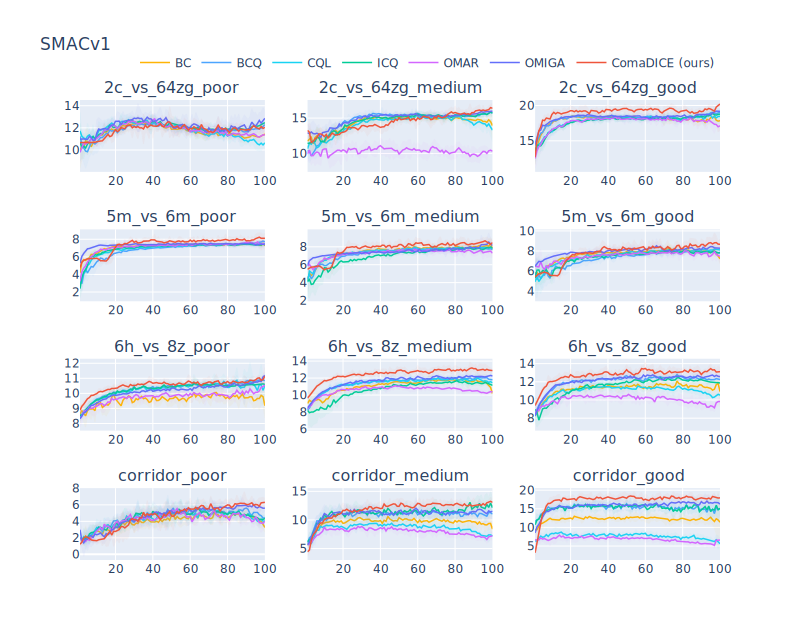

In [2801]:
fig = make_subplots(rows=4, cols=3, subplot_titles=[f"{env_name}_{mode}" for env_name in SMACV1_ENV_NAMES for mode in SMACV1_MODES])
for i, mode in enumerate(SMACV1_MODES):
    for j, env_name in enumerate(SMACV1_ENV_NAMES):
        plotly_fig = plotly_figs[(env_name, mode)]
        plotly_fig.write_image(f"graphs/{env_name}_{mode}_returns.pdf")
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)
fig.update_layout(height=640, width=800, title_text="SMACv1")
update_legend(fig, tag="returns")
fig.show("svg")

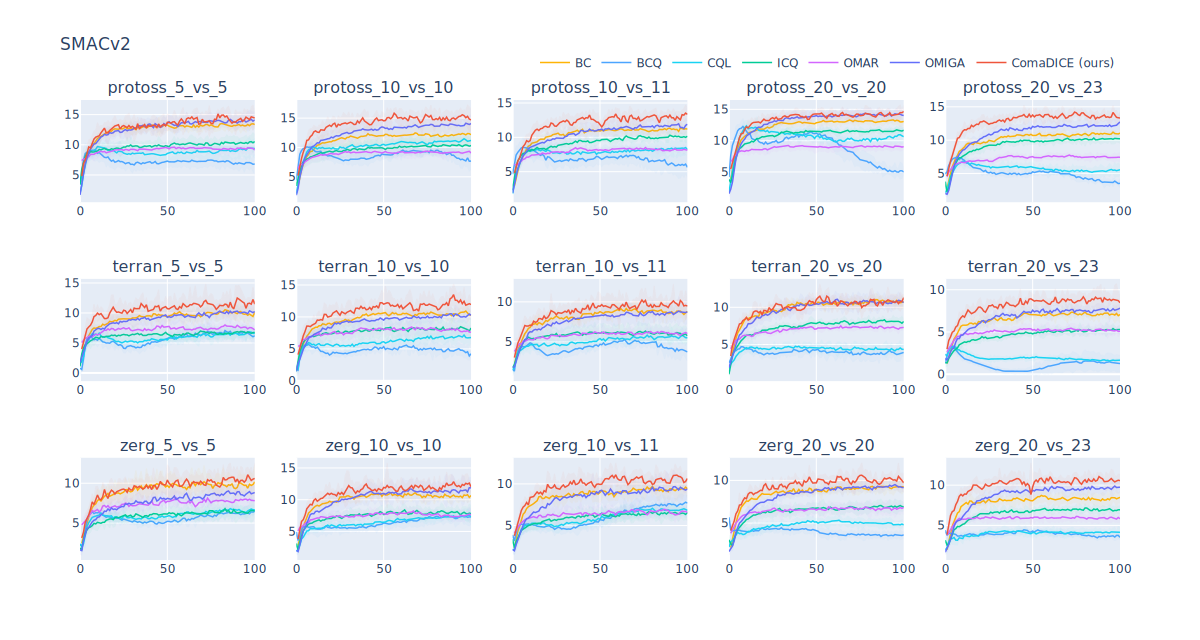

In [2802]:
fig = make_subplots(rows=3, cols=5, subplot_titles=[f"{env_name}_{mode}" for env_name in SMACV2_ENV_NAMES for mode in SMACV2_MODES])
for i, mode in enumerate(SMACV2_MODES):
    for j, env_name in enumerate(SMACV2_ENV_NAMES):
        plotly_fig = plotly_figs[(env_name, mode)]
        plotly_fig.write_image(f"graphs/{env_name}_{mode}_returns.pdf")
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)
fig.update_layout(height=640, width=1200, title_text="SMACv2")
update_legend(fig, tag="returns")
fig.show("svg")

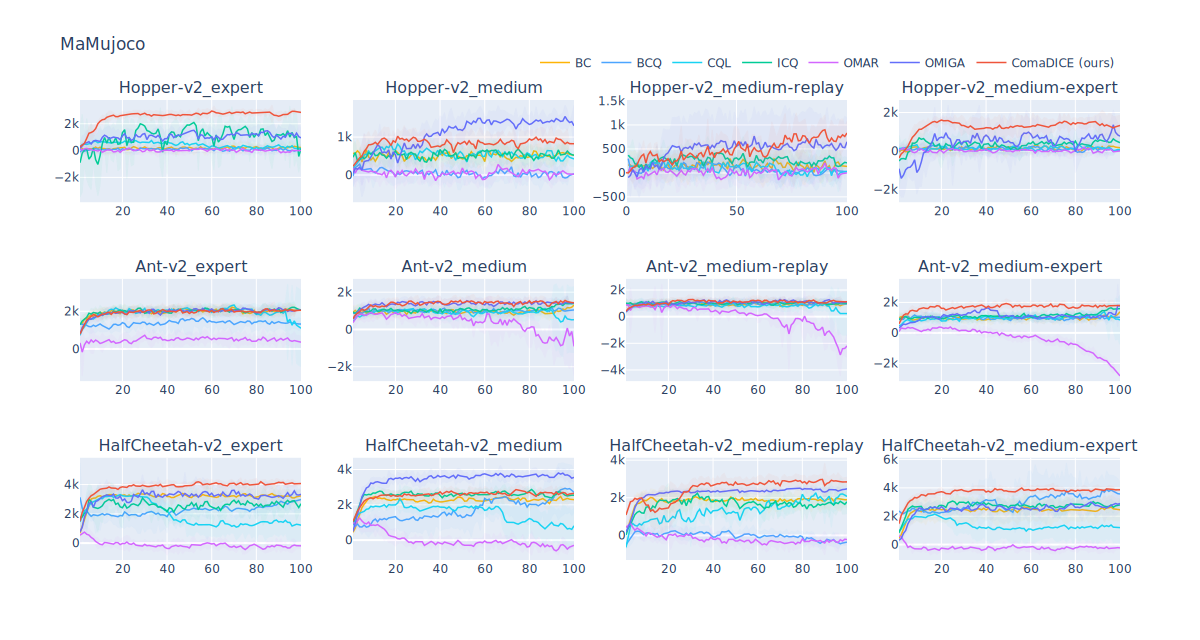

In [2803]:
fig = make_subplots(rows=3, cols=4, subplot_titles=[f"{env_name}_{mode}" for env_name in MAMUJOCO_ENV_NAMES for mode in MAMUJOCO_MODES])
for i, mode in enumerate(MAMUJOCO_MODES):
    for j, env_name in enumerate(MAMUJOCO_ENV_NAMES):
        plotly_fig = plotly_figs[(env_name, mode)]
        plotly_fig.write_image(f"graphs/{env_name}_{mode}_returns.pdf")
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)
fig.update_layout(height=640, width=1200, title_text="MaMujoco")
update_legend(fig, tag="returns")
fig.show("svg")

In [2804]:
plotly_figs = {}
y_range_dict = {
    "2c_vs_64zg": (1e-4, 0.599),
    "5m_vs_6m": (1e-4, 0.12),
    "6h_vs_8z": (1e-4, 0.16),
    "corridor": (1e-4, 0.599),
    "protoss": (1e-4, 0.599),
    "terran": (1e-4, 0.599),
    "zerg": (1e-4, 0.599),
}
for (env_name, mode), data in main_results.items():
    if env_name in MAMUJOCO_ENV_NAMES:
        continue
    y_range = y_range_dict.get(env_name)
    plotly_figs[(env_name, mode)] = create_scatters(data, y_range, "winrate", 0.6)

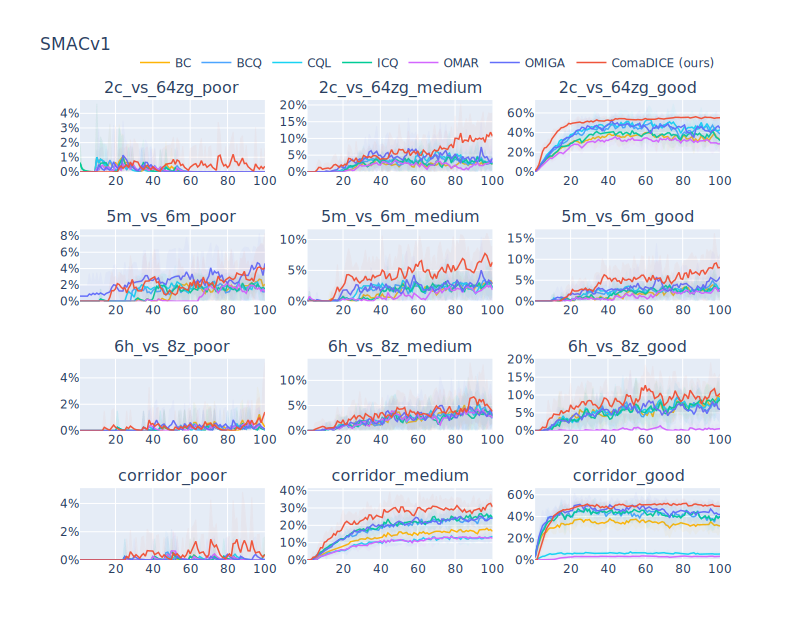

In [2805]:
fig = make_subplots(rows=4, cols=3, subplot_titles=[f"{env_name}_{mode}" for env_name in SMACV1_ENV_NAMES for mode in SMACV1_MODES])
for i, mode in enumerate(SMACV1_MODES):
    for j, env_name in enumerate(SMACV1_ENV_NAMES):
        plotly_fig = plotly_figs[(env_name, mode)]
        plotly_fig.write_image(f"graphs/{env_name}_{mode}_winrates.pdf")
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)
fig.update_layout(height=640, width=800, title_text="SMACv1")
update_legend(fig, tag="winrates")
fig.show("svg")

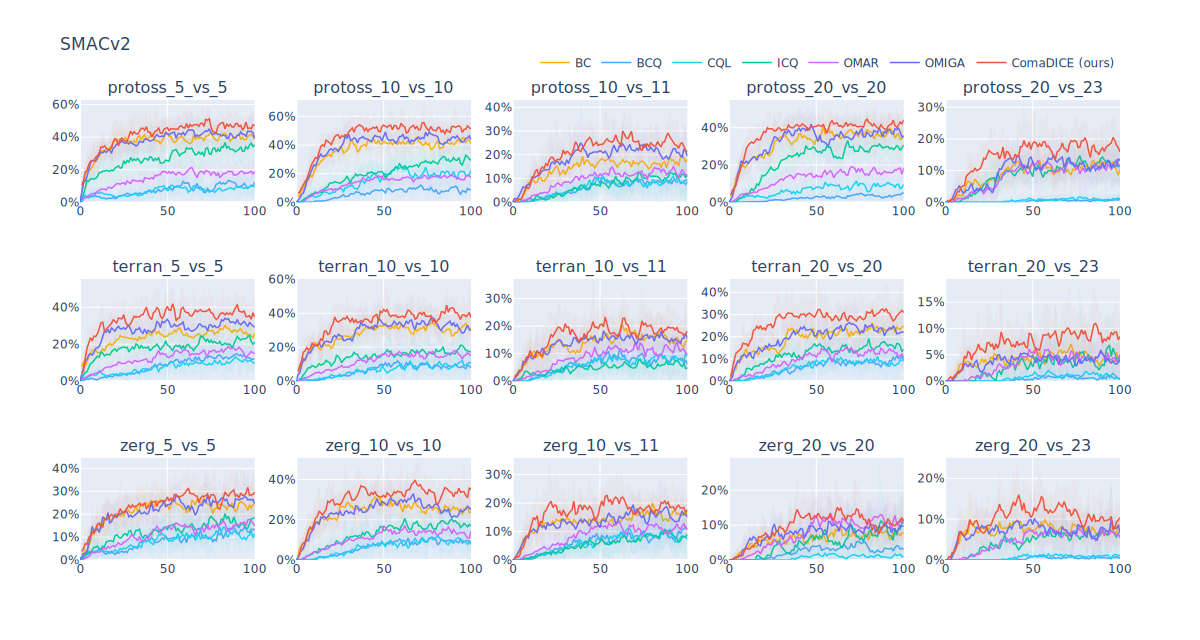

In [2806]:
fig = make_subplots(rows=3, cols=5, subplot_titles=[f"{env_name}_{mode}" for env_name in SMACV2_ENV_NAMES for mode in SMACV2_MODES])
for i, mode in enumerate(SMACV2_MODES):
    for j, env_name in enumerate(SMACV2_ENV_NAMES):
        plotly_fig = plotly_figs[(env_name, mode)]
        plotly_fig.write_image(f"graphs/{env_name}_{mode}_winrates.pdf")
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)
fig.update_layout(height=640, width=1200, title_text="SMACv2")
update_legend(fig, tag="winrates")
fig.show("svg")

In [2807]:
fig.update_layout(template='simple_white', margin=dict(l=4, r=4, t=4, b=4, pad=4, autoexpand=True))
fig.update_layout(height=300, width=1000, title_text=None)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.5, xanchor="right", x=1))
fig.write_image(f"graphs/legends.pdf")

In [2808]:
def get_data_info(filename):
    data = np.load(f"offline_data/{filename}.npz", allow_pickle=True)
    states = data["states"]
    obs = data["obs"]
    actions = data["actions"]
    rewards = data["rewards"]
    dones = data["dones"]
    avails = data.get("avails")
    actives = data["actives"]

    is_last = np.zeros_like(dones)
    is_last[:, :-1] = dones[:, 1:]

    n_trajs, _, n_agents, ob_dim = obs.shape
    st_dim = states.shape[-1]
    ac_dim = avails.shape[-1] if avails is not None else actions.shape[-1]
    if avails is None:
        st_dim = st_dim * n_agents
    rewards = rewards.sum(1)
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    n_trans = np.sum(actives)
    n_trajs = f"{n_trajs/1e3:.1f}K" if n_trajs < 1e6 else f"{n_trajs/1e3:.0f}K"
    n_trans = f"{n_trans/1e3:.1f}K" if n_trans < 1e6 else f"{n_trans/1e3:.0f}K"
    return {
        "n_trajs": n_trajs,
        "n_trans": n_trans,
        "n_agents": n_agents,
        "st_dim": st_dim,
        "ob_dim": ob_dim,
        "ac_dim": ac_dim,
        "reward": f"{avg_reward:.1f}±{std_reward:.1f}",
    }

In [2809]:
data_info = {}
with Pool(4) as p:
    tasks = []
    for env_name in SMACV1_ENV_NAMES:
        for mode in SMACV1_MODES:
            tasks.append((env_name, mode, p.submit(get_data_info, f"{env_name}_{mode}")))
    for env_name in SMACV2_ENV_NAMES:
        for mode in SMACV2_MODES:
            tasks.append((env_name, mode, p.submit(get_data_info, f"{env_name}_{mode}_medium")))
    for env_name in MAMUJOCO_ENV_NAMES:
        for mode in MAMUJOCO_MODES:
            env_conf_dict = {
                "Hopper-v2": "3x1",
                "Ant-v2": "2x4",
                "HalfCheetah-v2": "6x1",
            }
            env_conf = env_conf_dict[env_name]
            tasks.append((env_name, mode, p.submit(get_data_info, f"{env_name}-{env_conf}-{mode}")))
    for env_name, mode, task in tqdm(tasks):
        data_info[(env_name, mode)] = task.result()

100%|██████████| 39/39 [00:25<00:00,  1.54it/s]


In [2810]:
df = pd.DataFrame(data_info).T
df

n_trajs n_trans n_agents st_dim ob_dim ac_dim  \
2c_vs_64zg     poor             0.3K   21.7K        2    675    478     70   
               medium           1.0K   75.9K        2    675    478     70   
               good             1.0K  118.4K        2    675    478     70   
5m_vs_6m       poor             1.0K  113.7K        5    156    124     12   
               medium           1.0K  138.6K        5    156    124     12   
               good             1.0K  138.7K        5    156    124     12   
6h_vs_8z       poor             1.0K  145.5K        6    213    172     14   
               medium           1.0K  177.1K        6    213    172     14   
               good             1.0K  228.2K        6    213    172     14   
corridor       poor             1.0K  307.6K        6    435    346     30   
               medium           1.0K  756.1K        6    435    346     30   
               good             1.0K  601.0K        6    435    346     30   
protoss        5_vs_5           1.0K   60.8K        5    130     92     11   
               10_vs_10         1.0K   68.3K       10    310    182     16   
               10_vs_11         1.0K   62.9K       10    327    191     17   
               20_vs_20         1.0K   76.7K       20    820    362     26   
               20_vs_23         1.0K   65.0K       20    901    389     29   
terran         5_vs_5           1.0K   47.6K        5    120     82     11   
               10_vs_10         1.0K   56.4K       10    290    162     16   
               10_vs_11         1.0K   52.5K       10    306    170     17   
               20_vs_20         1.0K   63.0K       20    780    322     26   
               20_vs_23         1.0K   51.3K       20    858    346     29   
zerg           5_vs_5           1.0K   27.5K        5    120     82     11   
               10_vs_10         1.0K   31.9K       10    290    162     16   
               10_vs_11         1.0K   30.9K       10    306    170     17   
               20_vs_20         1.0K   35.4K       20    780    322     26   
               20_vs_23         1.0K   32.8K       20    858    346     29   
Hopper-v2      expert           1.5K  998.9K        3     42     14      1   
               medium           4.0K  915.4K        3     42     14      1   
               medium-replay    4.2K   1311K        3     42     14      1   
               medium-expert    5.5K   1914K        3     42     14      1   
Ant-v2         expert           1.0K   1000K        2    226    113      4   
               medium           1.0K   1000K        2    226    113      4   
               medium-replay    1.8K   1750K        2    226    113      4   
               medium-expert    2.0K   2000K        2    226    113      4   
HalfCheetah-v2 expert           1.0K   1000K        6    138     23      1   
               medium           1.0K   1000K        6    138     23      1   
               medium-replay    1.0K   1000K        6    138     23      1   
               medium-expert    2.0K   2000K        6    138     23      1   

                                     reward  
2c_vs_64zg     poor                 8.9±1.0  
               medium              13.0±1.4  
               good                19.9±1.3  
5m_vs_6m       poor                 8.5±1.2  
               medium              11.0±0.6  
               good                20.0±0.0  
6h_vs_8z       poor                 9.1±0.8  
               medium              12.0±1.3  
               good                17.8±2.1  
corridor       poor                 4.9±1.7  
               medium              13.1±1.3  
               good                19.9±1.0  
protoss        5_vs_5              16.8±6.3  
               10_vs_10            15.7±5.2  
               10_vs_11            15.3±5.7  
               20_vs_20            16.2±4.7  
               20_vs_23            14.0±4.5  
terran         5_vs_5              15.2±7.2  
               10_vs_10           